# LangGraph-Learning

## 0. 初始化

In [1]:
# 少包的时候打开下面安装
# %pip install langgraph==0.2.62 langsmith==0.2.10 langchain-openai==0.3.0 langchain_community==0.3.14 langchain_experimental==0.3.4
import os
from dotenv import load_dotenv
load_dotenv()

True

## 1. 聊天机器人
[官方文档](https://langchain-ai.github.io/langgraph/tutorials/introduction/)

### 1.1 简单机器人

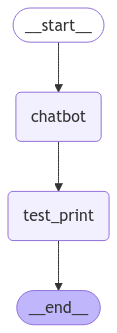

User: 1
AI: Hello! How can I assist you today?
[HumanMessage(content='1', additional_kwargs={}, response_metadata={}, id='ea5c5e47-e493-4181-8352-16ca0f45da99'), AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 8, 'total_tokens': 17, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_04751d0b65', 'finish_reason': 'stop', 'logprobs': None}, id='run-e2887ca6-af64-4786-9faa-37fc6f33c5b7-0', usage_metadata={'input_tokens': 8, 'output_tokens': 9, 'total_tokens': 17, 'input_token_details': {}, 'output_token_details': {}})]
AI: test_print
User: q


In [85]:
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, START, END
from typing_extensions import TypedDict
from typing import Annotated
from langgraph.graph.message import add_messages
from langchain_core.messages import HumanMessage,  AIMessage
from IPython.display import display, Image
import traceback


class State(TypedDict):
    messages: Annotated[list, add_messages] # Annotated将 add_messages 方法放到元数据中,  State.__annotations__['message'].__metadata__ 可以获得这个方法


graph_builder = StateGraph(State)
llm = ChatOpenAI(
    # model='gpt-4o-mini', 
    model='gpt-4o-2024-08-06', 
    api_key=os.environ['API_KEY'], 
    base_url=f"{os.environ['BASE_URL']}/v1"
)

def chatbot(state: State):
    return {"messages": [llm.invoke(state['messages'])]}

def test_print(state: State):
    print(state['messages'])      # 发现state只会保留当前一轮的对话信息
    return {"messages": [HumanMessage("test_print")]} 

graph_builder.add_node("chatbot", chatbot) # add_node 用于注册节点
graph_builder.add_node("test_print", test_print)
graph_builder.add_edge(START, "chatbot")   # add_edge 用于组合图
graph_builder.add_edge("chatbot", "test_print")
graph_builder.add_edge("test_print", END)
graph = graph_builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [("user", user_input)]}): # 每个node都会有一个event
        for value in event.values():
            print("AI:", value['messages'][-1].content)

while True:
    try:
        user_input = input("User: ")
        print("User: " + user_input)
        if user_input.lower() in ['quit', 'q']:
            break
        stream_graph_updates(user_input)
    except Exception as e:
        traceback.print_exc()
        break


### 1.2 工具调用机器人

工具测试



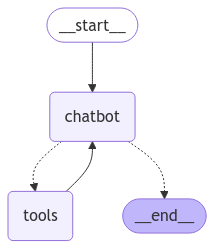

User: 用python帮我计算 1+1, 记得使用print输出结果
{'chatbot': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_DginOkcKQMed3h6FX5Rropbd', 'function': {'arguments': '{"__arg1":"print(1+1)"}', 'name': 'python_repl'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 102, 'total_tokens': 124, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_f3927aa00d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-b27ae12e-b0d4-4c92-ac88-15627465135f-0', tool_calls=[{'name': 'python_repl', 'args': {'__arg1': 'print(1+1)'}, 'id': 'call_DginOkcKQMed3h6FX5Rropbd', 'type': 'tool_call'}], usage_metadata={'input_tokens': 102, 'output_tokens': 22, 'total_tokens': 124, 'input_token_details': {'audio'

In [ ]:
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, START, END
from typing_extensions import TypedDict
from typing import Annotated
from langgraph.graph.message import add_messages
from langchain_core.messages import HumanMessage,  AIMessage
from IPython.display import display, Image
import traceback
from langchain_experimental.utilities import PythonREPL
from langchain_core.tools import Tool
from langchain_core.messages import ToolMessage
import json
from langgraph.prebuilt import ToolNode, tools_condition # 对于工具的封装


python_repl = PythonREPL()
tool = Tool(
    name="python_repl",
    description="A Python shell. Use this to execute python commands. Input should be a valid python command. If you want to see the output of a value, you should print it out with `print(...)`.",
    func=python_repl.run,
)
result = tool.invoke("print('工具测试')")   # 工具调用测试
print(result)


class State(TypedDict):
    messages: Annotated[list, add_messages]   # messages 不要写错 而且跟下面要对齐


graph_builder = StateGraph(State)
llm = ChatOpenAI(
    model='gpt-4o-2024-08-06', 
    api_key=os.environ['API_KEY'], 
    base_url=f"{os.environ['BASE_URL']}/v1"
)

llm_with_tools = llm.bind_tools([tool])     # 这里使用openai内置的tools调用功能, 绑定了tools, 他会自己判断使用哪个tool

def chat_bot(state: State):
    return {"messages": [llm_with_tools.invoke(state['messages'])]}

graph_builder.add_node("chatbot", chat_bot)

""" 使用langchain封装的工具类型, 从这里开始注释
class BasicToolsNode:    # 用于解释工具的具体实现, 实际开发不需要自己实现
    
    def __init__(self, tools: list):
        self.tools_by_name = {tool.name: tool for tool in tools}
        
    def __call__(self, input: dict) -> dict:
        if messages := input.get("messages", []):    
            message = messages[-1]
        else:
            raise Exception("no message")
        outputs = []
        for tool_call in message.tool_calls:   
            # 触发工具调用, llm会返回以下结构, 这是工具调用的基础
            # AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_pYXVVVSZUb8oLpe5FW3oe3rJ', 'function': {'arguments': '{"__arg1":"1 + 1"}', 'name': 'python_repl'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 94, 'total_tokens': 114, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_f3927aa00d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-296523b1-9710-4a3c-bc60-666f3710ffb1-0', tool_calls=[{'name': 'python_repl', 'args': {'__arg1': '1 + 1'}, 'id': 'call_pYXVVVSZUb8oLpe5FW3oe3rJ', 'type': 'tool_call'}], usage_metadata={'input_tokens': 94, 'output_tokens': 20, 'total_tokens': 114, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})
            tool_result = self.tools_by_name[tool_call['name']].invoke(
                tool_call['args']
            )
            outputs.append(
                ToolMessage(
                    content = json.dumps(tool_result),
                    name = tool_call['name'],
                    tool_call_id = tool_call['id']
                )
            )
        return {"messages": outputs}

tool_node = BasicToolsNode([tool])
graph_builder.add_node("tools", tool_node)

def route_tools(state: State) -> str: 
    if isinstance(state, list):
        ai_message = state[-1]
    elif message := state.get("messages", []):
        ai_message = message[-1]
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return END

graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    {"tools": "tools", END: END}
)
""" # 到这里结束
#""" 使用自己实现工具跳转 从这里开始注释
tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
#""" # 这里结束

graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [("user", user_input)]}):
        print(event)
        for value in event.values():
            if len(value['messages']) > 0:
                print("AI:", value["messages"][-1].content)

start = True
while True:
    try:
        if start: 
            user_input = "用python帮我计算 1+1, 记得使用print输出结果"  # 为了方便 第一次写死了
            start = False
        else: user_input = input("User: ") 
        print("User: " + user_input)
        if user_input.lower() in ['quit', 'q']:
            break
        stream_graph_updates(user_input)
    except Exception as e:
        traceback.print_exc()
        break


### 1.3 记忆机器人

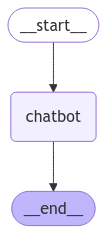

{'chatbot': {'messages': [AIMessage(content='你好，约翰！很高兴认识你！😊有什么我可以帮你的吗？', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 15, 'total_tokens': 35, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_f3927aa00d', 'finish_reason': 'stop', 'logprobs': None}, id='run-bb4d6a8e-7f51-49e9-aee5-f64ed40ba9b9-0', usage_metadata={'input_tokens': 15, 'output_tokens': 20, 'total_tokens': 35, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}}
{'chatbot': {'messages': [AIMessage(content='当然记得！你是约翰 😊。有什么需要帮忙或者聊聊的吗？', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 53, 'total_tokens': 73, 'completion_tok

In [ ]:
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, START, END
from typing_extensions import TypedDict
from typing import Annotated
from langgraph.graph.message import add_messages
from IPython.display import display, Image
import traceback
import json
from langgraph.checkpoint.memory import MemorySaver


memory = MemorySaver()  # langgraph 的记忆组件


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)
llm = ChatOpenAI(
    model='gpt-4o-2024-08-06', 
    api_key=os.environ['API_KEY'], 
    base_url=f"{os.environ['BASE_URL']}/v1"
)

def chat_bot(state: State):
    return {"messages": [llm.invoke(state['messages'])]}

graph_builder.add_node("chatbot", chat_bot)
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)
graph = graph_builder.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))
config = {
    "configurable": {"thread_id": "1"}  # 根据thread_id来区分记忆
}
for event in graph.stream({"messages": ("user", "你好, 我的名字是约翰")}, config=config):
    print(event)
for event in graph.stream({"messages": ("user", "你好, 你还记得我的名字吗")}, config=config):
    print(event)    # 此处有记忆
snapshot = graph.get_state(config)
print("当前存储的状态为: " + str(snapshot))
config = {
    "configurable": {"thread_id": "2"}
}
for event in graph.stream({"messages": ("user", "你好, 你还记得我的名字吗")}, config=config):
    print(event)   # 结果无记忆了

### 1.4 人工介入循环, 以及状态修改

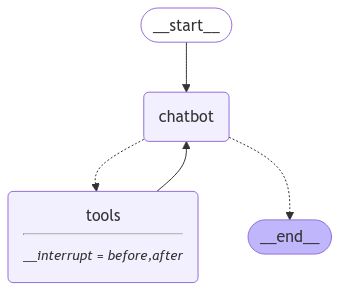

{'chatbot': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_4hRZQBytmnPHlKEOgAwJUukO', 'function': {'arguments': '{"__arg1":"print(1+1)"}', 'name': 'python_repl', 'parameters': None}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 99, 'total_tokens': 121, 'completion_tokens_details': {'accepted_prediction_tokens': None, 'audio_tokens': None, 'reasoning_tokens': None, 'rejected_prediction_tokens': None}, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': None}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_f3927aa00d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-a86a70ef-e3ea-4289-b142-dba6b96cb029-0', tool_calls=[{'name': 'python_repl', 'args': {'__arg1': 'print(1+1)'}, 'id': 'call_4hRZQBytmnPHlKEOgAwJUukO', 'type': 'tool_call'}], usage_metadata={'input_tokens': 99, 'output_tokens': 22, 'total_tokens': 121, 'input_token_details': {}, 'outp

In [ ]:
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, START, END
from typing_extensions import TypedDict
from typing import Annotated
from langgraph.graph.message import add_messages
from langchain_core.messages import HumanMessage,  AIMessage
from IPython.display import display, Image
import traceback
from langchain_experimental.utilities import PythonREPL
from langchain_core.tools import Tool
from langchain_core.messages import ToolMessage
import json
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver


memory = MemorySaver()


python_repl = PythonREPL()
tool = Tool(
    name="python_repl",
    description="A Python shell. Use this to execute python commands. Input should be a valid python command. If you want to see the output of a value, you should print it out with `print(...)`.",
    func=python_repl.run,
)


class State(TypedDict):
    messages: Annotated[list, add_messages]   


graph_builder = StateGraph(State)
llm = ChatOpenAI(
    model='gpt-4o-2024-08-06', 
    api_key=os.environ['API_KEY'], 
    base_url=f"{os.environ['BASE_URL']}/v1"
)

llm_with_tools = llm.bind_tools([tool])

def chat_bot(state: State):
    return {"messages": [llm_with_tools.invoke(state['messages'])]}

graph_builder.add_node("chatbot", chat_bot)
tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)

graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile(
    checkpointer=memory,
    interrupt_before=["tools"],
    interrupt_after=["tools"]
)
display(Image(graph.get_graph().draw_mermaid_png()))
config = {"configurable": {"thread_id": "1"}}
for event in graph.stream({"messages": [("user", "用python帮我计算1+1, 记得使用print")]}, config=config):
    print(event)
snapshot = graph.get_state(config)
print(snapshot.next)     # 这里在工具前打断成功
for event in graph.stream(None, config=config):
    print(event)
snapshot = graph.get_state(config)
print(snapshot.next)     # 这里在工具后打断成功
